In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
dataframe = pd.read_csv("/content/train.csv")

dataframe.head()

,Unnamed: 0,Policy_start_date,Age,Annual_premium,Vehicle_year,Claim_amount,Vehicle_risk_type,Area
0,1,2013-11-29,38,380.20,2013,0.0,2,0
1,2,2013-11-29,38,393.50,2013,0.0,2,0
2,3,2013-11-29,38,393.50,2013,0.0,2,0
3,4,2013-11-29,38,395.47,2013,0.0,2,0
4,5,2006-05-29,39,250.52,2006,0.0,2,0


In [3]:
dataframe = dataframe.drop(columns=["Unnamed: 0"])

# remove rows with same values
dataframe = dataframe.drop_duplicates()

In [4]:
# set random seed for reproducibility
# train_test_split
df_train, df_test = train_test_split(dataframe, test_size=0.2, random_state=42)
# train,validation
df_train, data_val = train_test_split(df_train, test_size=0.1, random_state=42)

In [5]:
def process_date_columns(dataframe: pd.DataFrame) -> pd.DataFrame:
    date_columns = [
        "Policy_start_date"
    ]

    # convert date columns to datetime
    dataframe[date_columns] = dataframe[date_columns].apply(
        pd.to_datetime, format="%Y-%m-%d", errors="coerce"
    )
    dataframe[('Policy_start_date')] = dataframe[('Policy_start_date')].values.astype("float64")

    return dataframe

In [6]:
def process_categorical_columns(dataframe: pd.DataFrame) -> pd.DataFrame:
    muti_categorical_columns = [
        "Vehicle_risk_type"
    ]

    # convert multi categorical columns to one hot encoding
    dataframe = pd.get_dummies(dataframe, columns=muti_categorical_columns)

    return dataframe

In [7]:
def process_numerical_columns(dataframe: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = [
        "Age",
        "Annual_premium",
        "Vehicle_year",
        "Claim_amount",
        "Policy_start_date"
    ]

    dataframe[numerical_columns] = dataframe[numerical_columns].apply(
        pd.to_numeric, errors="coerce"
    )
    # fill "Length" column with mean
    # dataframe["Length"] = dataframe["Length"].fillna(dataframe["Length"].mean())
    dataframe = dataframe.dropna()

    scaler = StandardScaler()
    dataframe[numerical_columns] = scaler.fit_transform(dataframe[numerical_columns])

    return dataframe

In [8]:
def process_binary_columns(dataframe: pd.DataFrame) -> pd.DataFrame:
    binary_columns = [
        "Area"
    ]
    # remove nan values
    dataframe[binary_columns] = dataframe[binary_columns].apply(
        pd.to_numeric, errors="coerce"
    )
    dataframe = dataframe.dropna()
    return dataframe

In [9]:
def process_data(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe = process_date_columns(dataframe)
    dataframe = process_categorical_columns(dataframe)
    dataframe = process_numerical_columns(dataframe)
    dataframe = process_binary_columns(dataframe)
    return dataframe


df_train = process_data(df_train)
df_test = process_data(df_test)
df_val = process_data(data_val)

In [10]:
df_train.head()

,Policy_start_date,Age,Annual_premium,Vehicle_year,Claim_amount,Area,Vehicle_risk_type_1,Vehicle_risk_type_2,Vehicle_risk_type_3
93724,0.588133,0.475765,1.407218,-0.178161,-0.099487,1,False,True,False
45035,0.441754,-0.306157,-1.018582,-0.348192,-0.099487,0,False,True,False
8229,0.812045,0.084804,-0.288282,-0.688253,-0.099487,0,False,True,False
47875,0.551371,0.475765,-0.266477,1.012054,-0.099487,0,False,True,False
71321,0.664998,0.319380,0.577591,-0.518223,5.098395,0,False,True,False


In [11]:
df_train.dtypes

,0
Policy_start_date,float64
Age,float64
Annual_premium,float64
Vehicle_year,float64
Claim_amount,float64
Area,int64
Vehicle_risk_type_1,bool
Vehicle_risk_type_2,bool
Vehicle_risk_type_3,bool


In [ ]:
# Hyperparameter tuning of bottleneck size
bottlenecks = [3, 5, 7, 10, 15, 20, 25, 30, 35, 40]
losses = []
for i in bottlenecks:
    input_dim = df_train.shape[1]
    encoding_dim = i

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = autoencoder.fit(
        df_train, df_train,
        epochs=50,
        batch_size=32,
        shuffle=True,
        validation_data=(df_val, df_val),
        callbacks=[early_stopping],
        verbose=0
    )
    loss = history.history['val_loss'][-1]
    losses.append(loss)
losses

[0.42222875356674194,
 0.3697963356971741,
 0.3634897470474243,
 0.36320334672927856,
 0.363476425409317,
 0.3629299998283386,
 0.3633345663547516,
 0.36320123076438904,
 0.36281439661979675,
 0.36290496587753296]

Text(0, 0.5, 'Validation Loss')

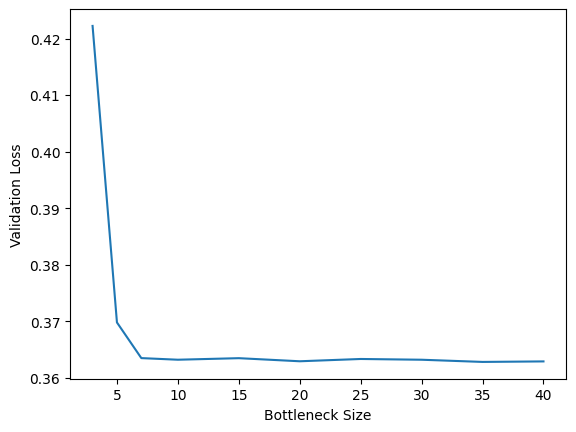

In [ ]:
plt.plot(bottlenecks, losses)
plt.xlabel('Bottleneck Size')
plt.ylabel('Validation Loss')

In [12]:
input_dim = df_train.shape[1]
encoding_dim = 7

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(
    df_train, df_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(df_val, df_val),
    callbacks=[early_stopping]
)


Epoch 1/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5256 - val_loss: 0.3845
Epoch 2/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5296 - val_loss: 0.3725
Epoch 3/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.3398 - val_loss: 0.3685
Epoch 4/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.3746 - val_loss: 0.3669
Epoch 5/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3907 - val_loss: 0.3664
Epoch 6/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3527 - val_loss: 0.3662
Epoch 7/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.3389 - val_loss: 0.3660
Epoch 8/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.3512 - val_loss: 0.3659
Epoch 9/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4441 - val_loss: 0.3658
Epoch 10/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3397 - val_loss: 0.3658
Epoch 11/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4257 - val_loss: 0.3657
Epoch 12/50
2102/2102 ━━━━━━━━

In [25]:
encoder = Model(input_layer, encoded)
latent_space = encoder.predict(df_test)

latent_variances = np.var(latent_space, axis=0)
top3_dims = np.argsort(latent_variances)[-3:]

top3_latent_space = latent_space[:, top3_dims]

df_test_reconstructed = autoencoder.predict(df_test)
reconstruction_error = np.mean(np.power(df_test - df_test_reconstructed, 2), axis=1)
threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold

584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


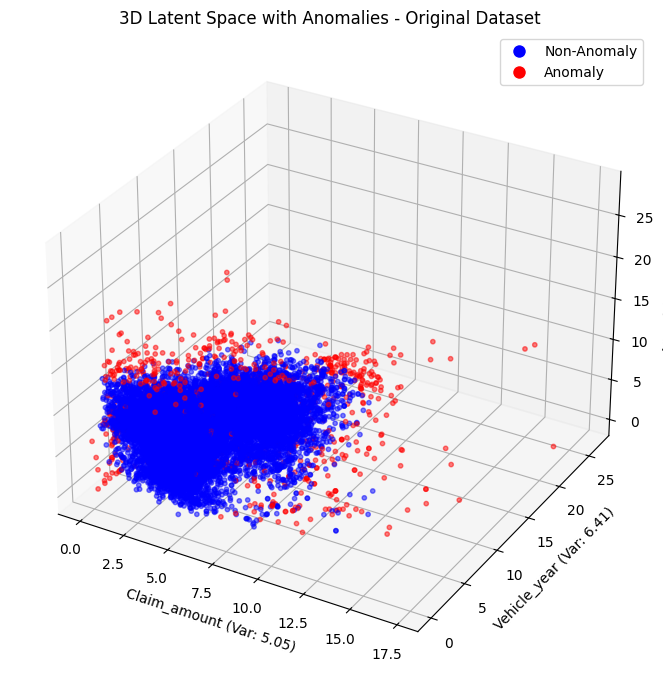

In [37]:
dimension_names = df_test.columns
top3_dim_names = [dimension_names[top3_dims[i]] for i in range(3)]

anomaly_colors = ['red' if is_anomaly else 'blue' for is_anomaly in anomalies]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    top3_latent_space[:, 0],
    top3_latent_space[:, 1],
    top3_latent_space[:, 2],
    c=anomaly_colors,
    s=10,
    alpha=0.5
)

# Set plot title and labels with specific dimension names and variances
ax.set_title('3D Latent Space with Anomalies - Original Dataset')
ax.set_xlabel(f'{top3_dim_names[0]} (Var: {latent_variances[top3_dims[0]]:.2f})')
ax.set_ylabel(f'{top3_dim_names[1]} (Var: {latent_variances[top3_dims[1]]:.2f})')
ax.set_zlabel(f'{top3_dim_names[2]} (Var: {latent_variances[top3_dims[2]]:.2f})')

# Add color legend for anomalies
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Non-Anomaly', markerfacecolor='blue', markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Anomaly', markerfacecolor='red', markersize=10)
plt.legend(handles=[blue_patch, red_patch], loc='best')

#plt.savefig("/content/3d_latent_space_plot.png", bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()


In [51]:
np.max(df_test - df_test_reconstructed)

56.500328552207144

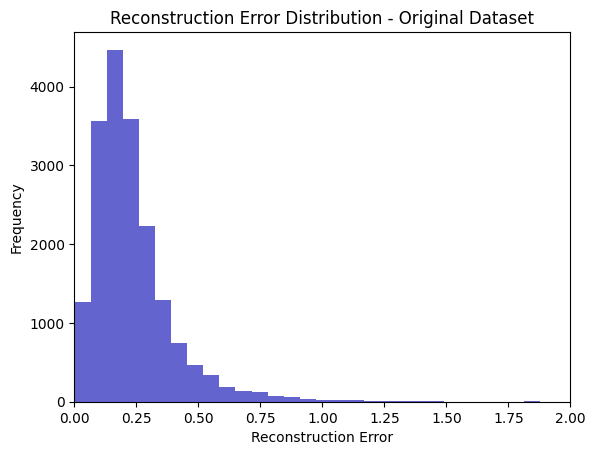

In [56]:
reconstruction_error = np.mean(np.abs(df_test - df_test_reconstructed), axis=1)

# Plot histogram of errors
plt.hist(reconstruction_error, bins=100, color='#2222bb', alpha=0.7)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution - Original Dataset')
plt.xlim(0, 2)
plt.show()

In [66]:
test2 = pd.read_csv("/content/test.csv")

test2.head()

,Unnamed: 0,Policy_start_date,Age,Annual_premium,Vehicle_year,Claim_amount,Vehicle_risk_type,Area,fraud_reported
0,1,2014-10-17,48,1406.91,2004,71610,2,1.0,Y
1,2,2006-06-27,42,1197.22,2007,5070,2,1.0,Y
2,3,2000-09-06,29,1413.14,2007,34650,3,1.0,N
3,4,1990-05-25,41,1415.74,2014,63400,2,1.0,Y
4,5,2014-06-06,44,1583.91,2009,6500,2,1.0,N


In [69]:
test2 = test2.drop(columns=["Unnamed: 0"])

# remove rows with same values
test2 = test2.drop_duplicates()

In [70]:
test2 = process_data(test2)

<ipython-input-7-ade6ea3d4663>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[numerical_columns] = scaler.fit_transform(dataframe[numerical_columns])


In [71]:
encoder2 = Model(input_layer, encoded)
latent_space2 = encoder2.predict(test2.drop(columns=["fraud_reported"]))

latent_variances2 = np.var(latent_space2, axis=0)
top3_dims2 = np.argsort(latent_variances2)[-3:]

top3_latent_space2 = latent_space2[:, top3_dims2]

df_test_reconstructed2 = autoencoder.predict(test2.drop(columns=["fraud_reported"]))
reconstruction_error2 = np.mean(np.power(test2.drop(columns=["fraud_reported"]) - df_test_reconstructed2, 2), axis=1)
threshold2 = np.percentile(reconstruction_error2, 75.37)
anomalies2 = reconstruction_error2 > threshold2

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


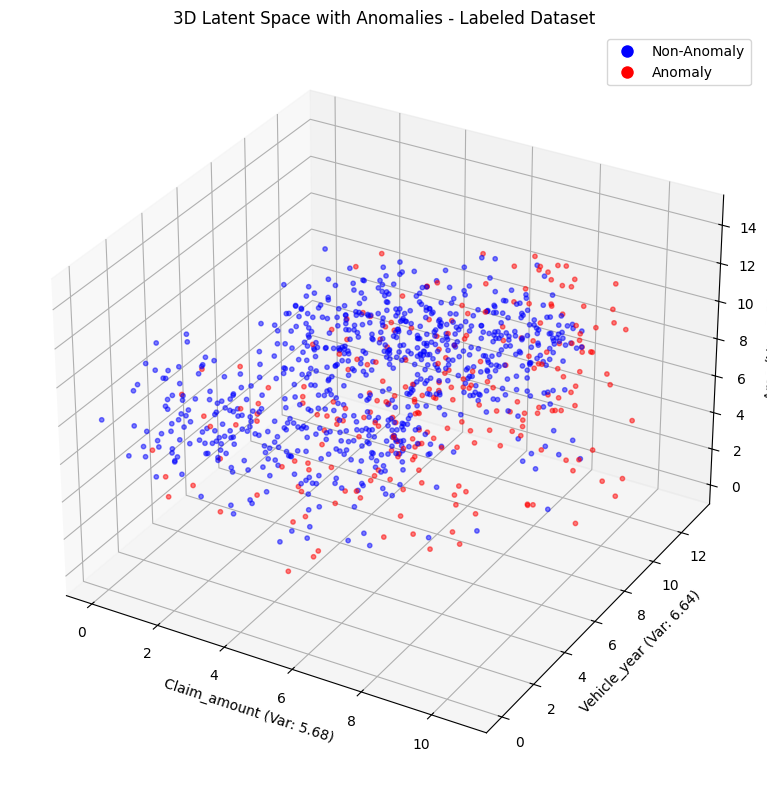

In [72]:
dimension_names2 = test2.drop(columns=["fraud_reported"]).columns
top3_dim_names2 = [dimension_names2[top3_dims[i]] for i in range(3)]

# Binary color scheme: Anomalies (red), Non-anomalies (blue)
anomaly_colors2 = ['red' if is_anomaly else 'blue' for is_anomaly in anomalies2]

# Create 3D plot
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    top3_latent_space2[:, 0],
    top3_latent_space2[:, 1],
    top3_latent_space2[:, 2],
    c=anomaly_colors2,  # Binary color scheme
    s=10,
    alpha=0.5
)

# Set plot title and labels with specific dimension names and variances
ax.set_title('3D Latent Space with Anomalies - Labeled Dataset')
ax.set_xlabel(f'{top3_dim_names2[0]} (Var: {latent_variances2[top3_dims2[0]]:.2f})')
ax.set_ylabel(f'{top3_dim_names2[1]} (Var: {latent_variances2[top3_dims2[1]]:.2f})')
ax.set_zlabel(f'{top3_dim_names2[2]} (Var: {latent_variances2[top3_dims2[2]]:.2f})')

# Add color legend for anomalies
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Non-Anomaly', markerfacecolor='blue', markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Anomaly', markerfacecolor='red', markersize=10)
plt.legend(handles=[blue_patch, red_patch], loc='best')


# Display plot
plt.tight_layout()
plt.show()

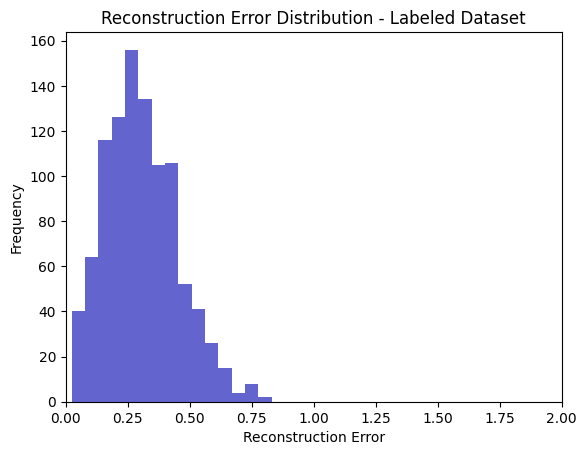

In [73]:
reconstruction_error2 = np.mean(np.abs(test2.drop(columns=["fraud_reported"]) - df_test_reconstructed2), axis=1)

# Plot histogram of errors
plt.hist(reconstruction_error2, bins=15, color='#2222bb', alpha=0.7)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution - Labeled Dataset')
plt.xlim(0, 2)
plt.show()

In [74]:
test2['is_anomaly'] = anomalies2

In [75]:
test2.head()

,Policy_start_date,Age,Annual_premium,Vehicle_year,Claim_amount,Area,fraud_reported,Vehicle_risk_type_1,Vehicle_risk_type_2,Vehicle_risk_type_3,is_anomaly
0,1.724154,0.987702,0.618093,-0.182562,0.712981,1.0,Y,False,True,False,False
1,0.595300,0.331067,-0.239673,0.316018,-1.807008,1.0,Y,False,True,False,False
2,-0.193484,-1.091642,0.643578,0.316018,-0.686761,1.0,N,False,False,True,False
3,-1.591343,0.221628,0.654214,1.479371,0.402053,1.0,Y,False,True,False,False
4,1.674669,0.549946,1.342136,0.648404,-1.752852,1.0,N,False,True,False,False


In [76]:
test2['fraud_reported'].value_counts()

,count
fraud_reported,
N,750
Y,245


In [77]:
pd.crosstab(test2['is_anomaly'], test2['fraud_reported'])

fraud_reported,N,Y
is_anomaly,,
False,560,190
True,190,55


In [78]:
top3_dim_names2

['Claim_amount', 'Vehicle_year', 'Area']

In [79]:
test2['fraud_reported'] = test2['fraud_reported'].replace({'Y': True, 'N': False})


<ipython-input-79-87e1c20376d8>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test2['fraud_reported'] = test2['fraud_reported'].replace({'Y': True, 'N': False})


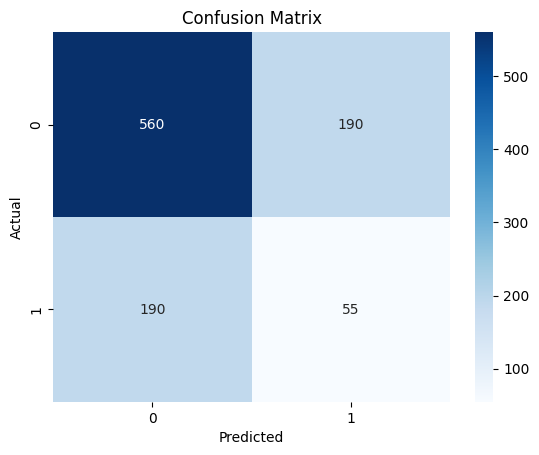

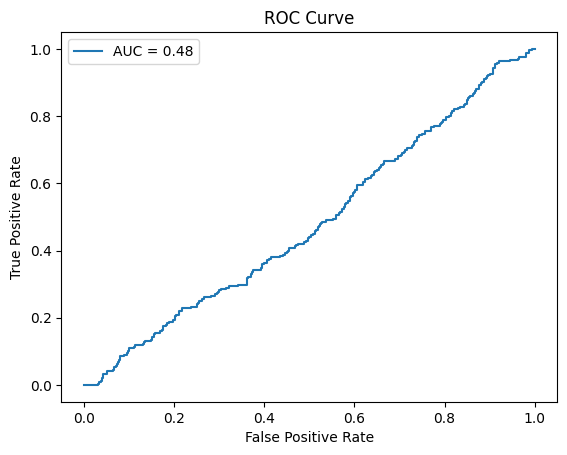

In [80]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
# Confusion Matrix
cm = confusion_matrix(test2["fraud_reported"], test2["is_anomaly"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test2["fraud_reported"], reconstruction_error2)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [81]:
test2.to_csv("/content/test_labeled.csv")